## Lineage Auto Tracking with MNIST Handwritten Digits Example

This demo shows how SageMaker Lineage metadata is auto generated during training.

1. Setup the beta SDK. 
1. Download and prepare the MNIST dataset.
1. Train a Convolutional Neural Network (CNN) Model.
1. Traverse the auto generated lineage entities.

Make sure you selected `conda_mxnet_p36` kernel.

Make sure:
* your account has been whitelisted
* your execution role has the appropriate trusts

In [1]:
import sys

!{sys.executable} -m pip install -q -U pip
!{sys.executable} -m pip install -q sagemaker-2.6.1.dev0.tar.gz

In [2]:
import IPython
#may need to restart the kernel after initial install of beta sdk
#IPython.Application.instance().kernel.do_shutdown(True)

### Install Python SDKs

In [3]:
import sys
import os

In [4]:
!{sys.executable} -m pip install sagemaker-experiments

### Setup

In [5]:
import time

import boto3
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [6]:
# lineage beta only available in CMH
region = 'us-east-2'

sess = boto3.Session(region_name=region)
sm = sess.client('sagemaker')
role = get_execution_role()

### Create a S3 bucket to hold data

In [7]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
bucket = 'sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
prefix = 'mnist'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print(e)

An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.


### Create an Experiment

In [8]:
mnist_experiment = Experiment.create(
    experiment_name=f"mnist-hand-written-digits-classification-{int(time.time())}", 
    description="Classification of mnist hand-written digits", 
    sagemaker_boto_client=sm)
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7fa9c1f5eda0>,experiment_name='mnist-hand-written-digits-classification-1600448285',description='Classification of mnist hand-written digits',tags=None,experiment_arn='arn:aws:sagemaker:us-east-2:707662012936:experiment/mnist-hand-written-digits-classification-1600448285',response_metadata={'RequestId': 'eaf6dbea-6ecb-4781-9167-53ead98746b7', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'eaf6dbea-6ecb-4781-9167-53ead98746b7', 'content-type': 'application/x-amz-json-1.1', 'content-length': '123', 'date': 'Fri, 18 Sep 2020 16:58:05 GMT'}, 'RetryAttempts': 0})


### Create a Trial For Each Training Run

Note the execution of the following code takes a while.

In [9]:
from sagemaker.mxnet import MXNet
from sagemaker import get_execution_role

# Bucket location where results of model training are saved.
model_artifacts_location = 's3://{}/mxnet-mnist-example/artifacts'.format(bucket)
custom_code_upload_location = 's3://{}/mxnet-mnist-example/code'.format(bucket)
train_data_location = 's3://sagemaker-sample-data-{}/mxnet/mnist/train'.format(region)
test_data_location = 's3://sagemaker-sample-data-{}/mxnet/mnist/test'.format(region)
# IAM execution role that gives SageMaker access to resources in your AWS account.
# We can use the SageMaker Python SDK to get the role from our notebook environment. 
role = get_execution_role()

If you want to run the following training jobs asynchronously, you may need to increase your resource limit. Otherwise, you can run them sequentially.

In [10]:
# create trial
trial_name = f"cnn-training-job-{int(time.time())}"
cnn_trial = Trial.create(
    trial_name=trial_name, 
    experiment_name=mnist_experiment.experiment_name,
    sagemaker_boto_client=sm,
)

In [12]:
# all input configurations, parameters, and metrics specified in estimator 
# definition are automatically tracked
from sagemaker.mxnet import MXNet

estimator = MXNet(entry_point='mnist.py',
                    role=role,
                    output_path=model_artifacts_location,
                    code_location=custom_code_upload_location,
                    instance_count=1,
                    instance_type='ml.m4.xlarge',
                    framework_version='1.4.1',
                    py_version='py3',
                    #distributions={'parameter_server': {'enabled': True}},
                    hyperparameters={'learning-rate': 0.1})

cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))

# Now associate the estimator with the Experiment and Trial
estimator.fit(
    inputs={'train': train_data_location, 'test': test_data_location},
    job_name=cnn_training_job_name,
    experiment_config={
        "TrialName": cnn_trial.trial_name,
        "TrialComponentDisplayName": "Training",
    },
    wait=True,
)

INFO:sagemaker:Creating training-job with name: cnn-training-job-1600448298


2020-09-18 16:58:19 Starting - Starting the training job...
2020-09-18 16:58:21 Starting - Launching requested ML instances......
2020-09-18 16:59:24 Starting - Preparing the instances for training...
2020-09-18 17:00:14 Downloading - Downloading input data...
2020-09-18 17:00:38 Training - Downloading the training image..
2020-09-18 17:00:57 Training - Training image download completed. Training in progress.2020-09-18 17:00:58,918 sagemaker-containers INFO     Imported framework sagemaker_mxnet_container.training
2020-09-18 17:00:58,922 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-09-18 17:00:58,936 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{"learning-rate":0.1}', 'SM_USER_ENTRY_POINT': 'mnist.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_name":"eth0"}', 'SM_INPUT_DATA_CON

### View the Lineage Data

Now we will traverse the lineage metadata auto generated by SageMaker for the previously created training job.

In [13]:
from sagemaker.lineage.association import Association

In [14]:
trial_component_name = cnn_training_job_name + '-aws-training-job'
trial_component = TrialComponent.load(trial_component_name=trial_component_name, sagemaker_boto_client=sm)
tc_arn = trial_component.trial_component_arn

# Incoming Associations
incoming_associations = Association.list(destination_arn=tc_arn, sagemaker_boto_client=sm)

print(f'\nLineage entities upstream from {tc_arn}:')
for association in incoming_associations:
    print(association.source_arn)

# Outgoing Assocaitions
outgoing_associations = Association.list(source_arn=tc_arn, sagemaker_boto_client=sm)
print(f'\nLineage entities downstream from {tc_arn}:')
for association in outgoing_associations:
    print(association.destination_arn)


Lineage entities upstream from arn:aws:sagemaker:us-east-2:707662012936:experiment-trial-component/cnn-training-job-1600448298-aws-training-job:
arn:aws:sagemaker:us-east-2:707662012936:artifact/670e8b0c6229188481e498f852cad181
arn:aws:sagemaker:us-east-2:707662012936:artifact/9f4e6150b0cb6b66b70038d62c60c287
arn:aws:sagemaker:us-east-2:707662012936:artifact/faa0f168c72092323e13042098253e44

Lineage entities downstream from arn:aws:sagemaker:us-east-2:707662012936:experiment-trial-component/cnn-training-job-1600448298-aws-training-job:


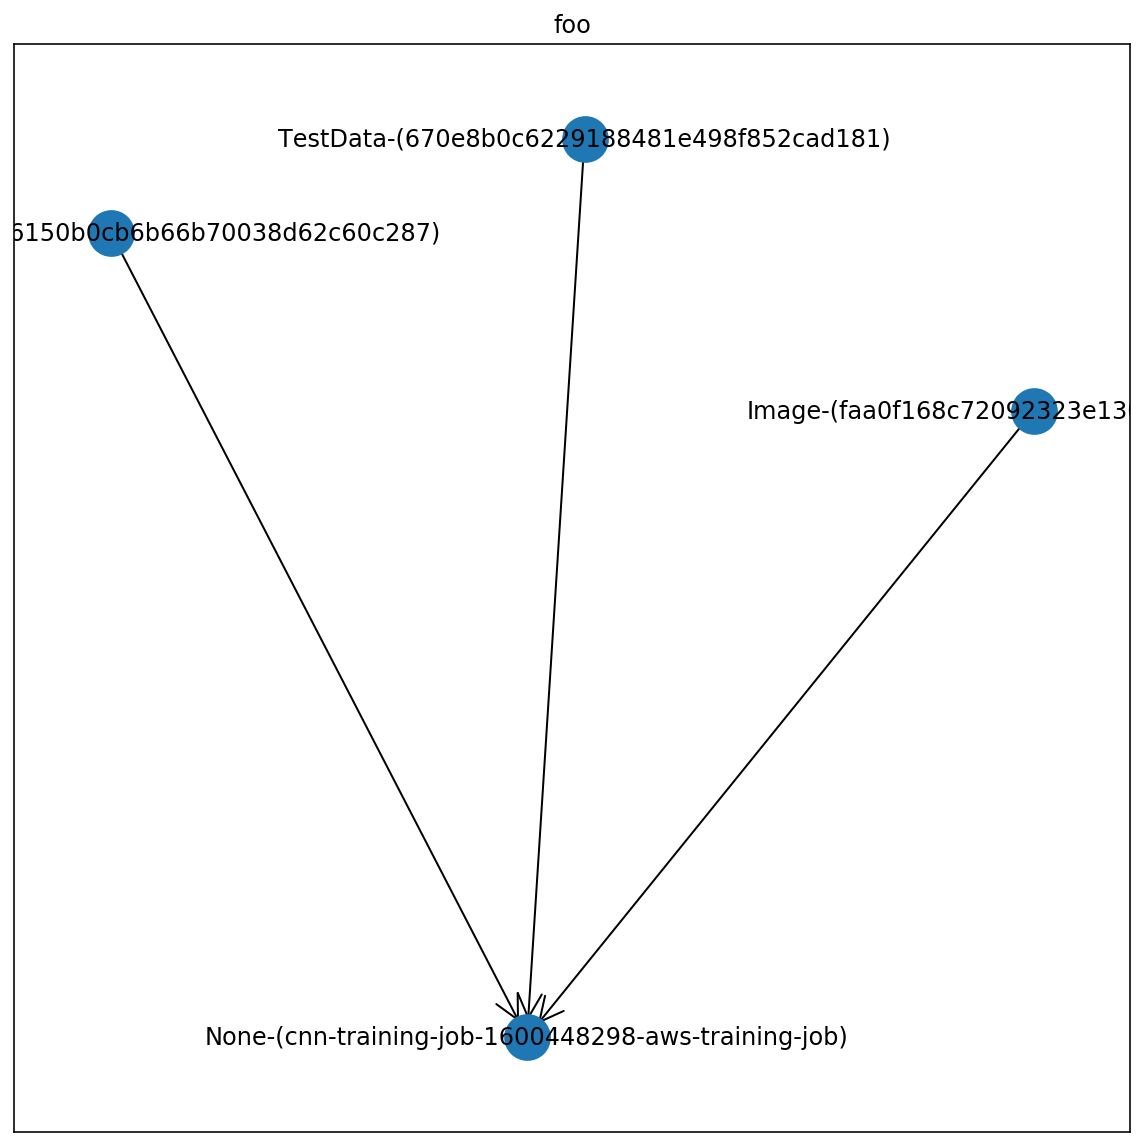

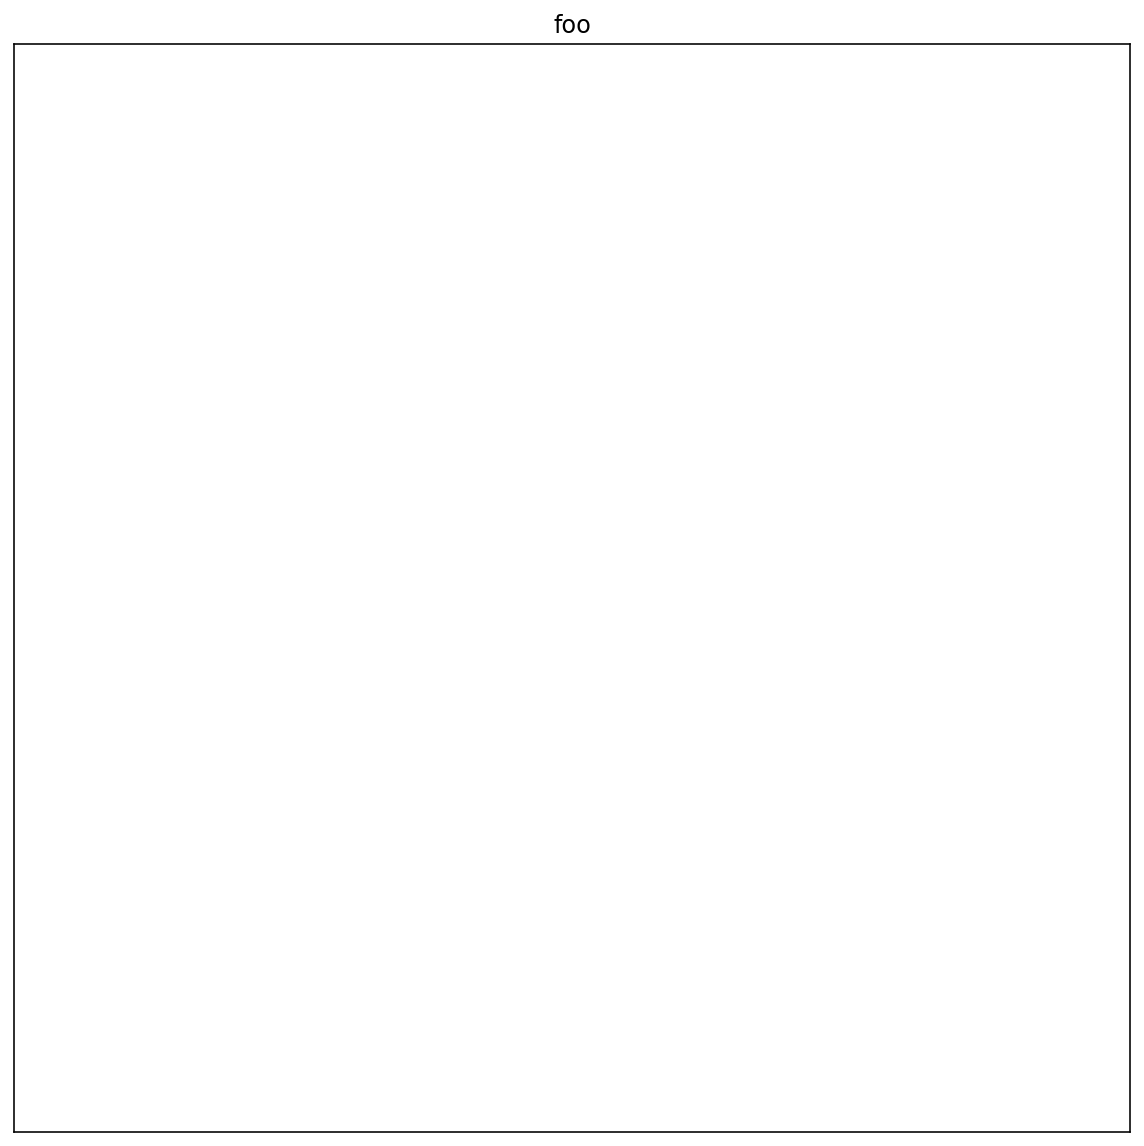

In [18]:
%run lineage_visualizer.py

import lineage_visualizer

# plot a rough visualization of the linaege artifacts
vis = LineageVisualizer(sm)
vis.upstream(tc_arn)

vis.downstream(tc_arn)

In [19]:
# represent lineage as yaml
file_name = vis.write_yaml()
f = open(file_name, "r")
print(f.read())

!!python/object:networkx.classes.digraph.DiGraph
_adj: &id001 {}
_node: &id003 {}
_pred: {}
_succ: *id001
adjlist_inner_dict_factory: &id002 !!python/name:builtins.dict ''
adjlist_outer_dict_factory: *id002
edge_attr_dict_factory: *id002
graph: {}
graph_attr_dict_factory: *id002
node_attr_dict_factory: *id002
node_dict_factory: *id002
nodes: !!python/object:networkx.classes.reportviews.NodeView
  _nodes: *id003

